In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import spm1d
import statsmodels.stats.power as smp

In [2]:
#import raw data and transpose it
data = pd.read_csv('Moments.csv', header=None).T

#drop the columns with sides that are not relevant - i.e. only interested with prosthesis side
locations_of_unwanted_data = np.array([0,2,4,6,8,10,12,14,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,55,57,59,61,63,65,67,69,87,89,91,93,96,98,100,102]) + 1
data = data.drop(locations_of_unwanted_data, axis=1)

#create headers from the first 3 rows (name, method A or B, and side and joint)
headers = data.iloc[0].str.cat(data.iloc[1].str.cat(data.iloc[2], sep='; '), sep='; ')

#drop the rows that had the header information in
data = data.drop([0,1,2,3,4])

#rename the columns
data.columns = headers

#get hip and knee moments for Method A and Method B
#seperate all hip and knee moments
hip_moments = data[data.columns[data.columns.str.contains('Hip')]]
knee_moments = data[data.columns[data.columns.str.contains('Knee')]]
#get method a and method b data (OG relates to 'original' i.e. Method A)
hip_OG_moments = hip_moments[hip_moments.columns[hip_moments.columns.str.contains('OG')]]
hip_PyCGM2_moments = hip_moments[hip_moments.columns[~hip_moments.columns.str.contains('OG')]]
knee_OG_moments = knee_moments[knee_moments.columns[knee_moments.columns.str.contains('OG')]]
knee_PyCGM2_moments = knee_moments[knee_moments.columns[~knee_moments.columns.str.contains('OG')]]

#get swing phase moments - the last 40% of the data (50 data points total)
swing_phase_start_index = np.rint((data.shape[0]*0.7) - 1)
#print(swing_phase_start_index)
swing_phase = data.iloc[int(swing_phase_start_index):]

#get hip and knee moments for Method A and Method B during swing phase
#seperate all hip and knee moments
hip_swing_moments = swing_phase[swing_phase.columns[swing_phase.columns.str.contains('Hip')]]
knee_swing_moments = swing_phase[swing_phase.columns[swing_phase.columns.str.contains('Knee')]]
#get method a and method b data (OG relates to 'original' i.e. Method A)
hip_OG_swing_moments = hip_swing_moments[hip_swing_moments.columns[hip_swing_moments.columns.str.contains('OG')]]
hip_PyCGM2_swing_moments = hip_swing_moments[hip_swing_moments.columns[~hip_swing_moments.columns.str.contains('OG')]]
knee_OG_swing_moments = knee_swing_moments[knee_swing_moments.columns[knee_swing_moments.columns.str.contains('OG')]]
knee_PyCGM2_swing_moments = knee_swing_moments[knee_swing_moments.columns[~knee_swing_moments.columns.str.contains('OG')]]

# hip_OG_moments, hip_PyCGM2_moments, knee_OG_moments, knee_PyCGM2_moments
# hip_OG_swing_moments, hip_PyCGM2_swing_moments, knee_OG_swing_moments, knee_PyCGM2_swing_moments

iqr is 0.14500000000000005, p25 is 0.13999999999999999, p75 is 0.28500000000000003
outliers in the hip data are : []
outliers in the knee data are : []
0.9999853496855012
0.9999955215096942


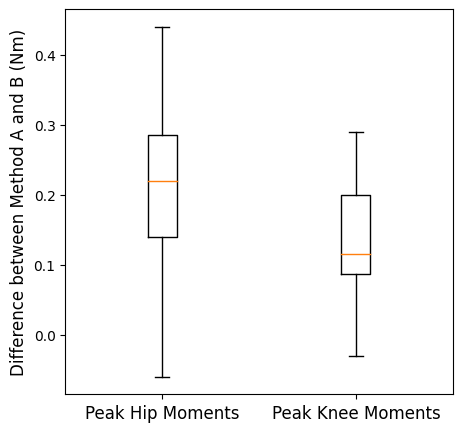

In [3]:
#Comparison of peak hip and knee moments during swing phase

#peak moments during swing
peak_hip_moments_OG = np.array(hip_OG_swing_moments.abs().max())
peak_hip_moments_PyCGM2 = np.array(hip_PyCGM2_swing_moments.abs().max())
peak_knee_moments_OG = np.array(knee_OG_swing_moments.abs().max())
peak_knee_moments_PyCGM2 = np.array(knee_PyCGM2_swing_moments.abs().max())

#difference between OG and PyCGM2 peak moments
hip_moment_difference = peak_hip_moments_OG - peak_hip_moments_PyCGM2
knee_moment_difference = peak_knee_moments_OG - peak_knee_moments_PyCGM2

#percentage difference with respect to original data
hip_moment_percentage_difference = 100*hip_moment_difference/peak_hip_moments_OG
knee_moment_percentage_difference = 100*knee_moment_difference/peak_knee_moments_OG

#identify outliers
#hip
iqr = stats.iqr(hip_moment_difference)
p75, p25 = np.percentile(hip_moment_difference, [75, 25])
outliers = hip_moment_difference[(hip_moment_difference < (p25 - 1.5*iqr)) & (hip_moment_difference < (p75 + 1.5*iqr))]
print('iqr is {}, p25 is {}, p75 is {}'.format(iqr,p25,p75))
print('outliers in the hip data are :', outliers)
#knee
iqr = stats.iqr(knee_moment_difference)
p75, p25 = np.percentile(knee_moment_difference, [75, 25])
outliers = knee_moment_difference[(knee_moment_difference < (p25 - 1.5*iqr)) & (knee_moment_difference < (p75 + 1.5*iqr))]
print('outliers in the knee data are :', outliers)

#summary statistics
headers = ['Peak Hip Moment Difference','Peak Knee Moment Difference']
stats_tests_names = ['Mean', 'Mean of Percentage Difference','Median', 'Standard Deviation', 'Paired T-Test Statistic', 'p-Value', '95% Confidence Interval', '5% Confidence Interval']
means = [hip_moment_difference.mean(), knee_moment_difference.mean()]
percent_means = [hip_moment_percentage_difference.mean(), knee_moment_percentage_difference.mean()]
medians = [np.median(hip_moment_difference), np.median(knee_moment_difference)]
std_dv = [np.std(hip_moment_difference), np.std(knee_moment_difference)]
t_stat = [stats.ttest_rel(peak_hip_moments_OG, peak_hip_moments_PyCGM2)[0], stats.ttest_rel(peak_knee_moments_OG, peak_knee_moments_PyCGM2)[0]]
p_value = [stats.ttest_rel(peak_hip_moments_OG, peak_hip_moments_PyCGM2)[1], stats.ttest_rel(peak_knee_moments_OG, peak_knee_moments_PyCGM2)[1]]
high_CI = [stats.ttest_rel(peak_hip_moments_OG, peak_hip_moments_PyCGM2).confidence_interval(confidence_level=0.95)[1],
           stats.ttest_rel(peak_knee_moments_OG, peak_knee_moments_PyCGM2).confidence_interval(confidence_level=0.95)[1]]
low_CI = [stats.ttest_rel(peak_hip_moments_OG, peak_hip_moments_PyCGM2).confidence_interval(confidence_level=0.95)[0],
           stats.ttest_rel(peak_knee_moments_OG, peak_knee_moments_PyCGM2).confidence_interval(confidence_level=0.95)[0]]
Peak_Moment_Differences_Statistics = pd.DataFrame(data=np.array([means,percent_means,medians,std_dv,t_stat,p_value,high_CI,low_CI]), index=stats_tests_names, columns=headers)

#box plots to identify outliers
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.boxplot([hip_moment_difference, knee_moment_difference], labels=['Peak Hip Moments','Peak Knee Moments'])
plt.xticks(fontsize=12)
axs.set_ylabel('Difference between Method A and B (Nm)',  fontsize=12)
fig.savefig('Outputs/peak hip and knee moments boxplot.png', bbox_inches='tight')

Peak_Moment_Differences_Statistics.to_csv('Outputs/peak hip and knee moments summary statistics 70.csv')

normaility_test = open("Outputs/Normality Test.txt","w+")
normaility_test.write('The Shapiro Wilks test for normality resulted in: \n')
normaility_test.write(str(stats.shapiro(hip_moment_difference)) + 'for the difference in peak hip flexion moments, and \n')
normaility_test.write(str(stats.shapiro(knee_moment_difference)) + 'for the difference in peak knee flexion moments. \n')
normaility_test.close()

power_analysis = smp.TTestPower()
print(power_analysis.power(means[0]/std_dv[0], len(peak_hip_moments_OG), 0.05, df=None, alternative='two-sided'))
print(power_analysis.power(means[1]/std_dv[1], len(peak_knee_moments_OG), 0.05, df=None, alternative='two-sided'))

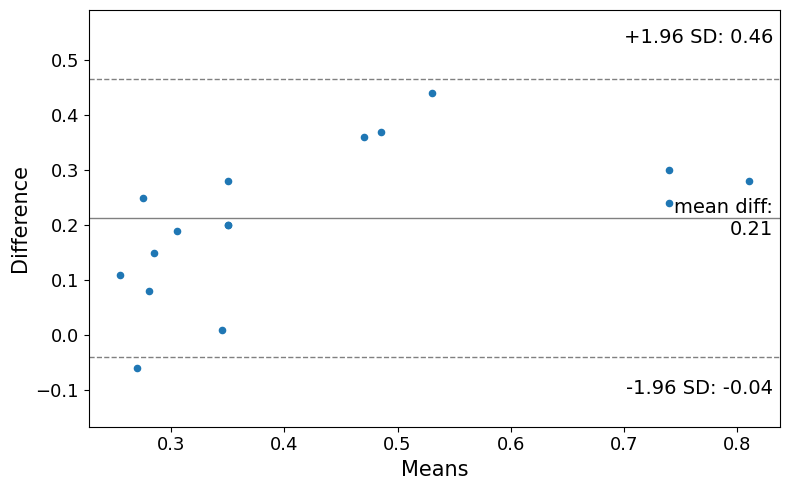

In [4]:
import statsmodels.api as sm

#create Bland-Altman plot                  
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(peak_hip_moments_OG, peak_hip_moments_PyCGM2, ax = ax)

#display Bland-Altman plot
plt.show()
f.savefig('Outputs/peak hip moments bland altman.png', bbox_inches='tight')

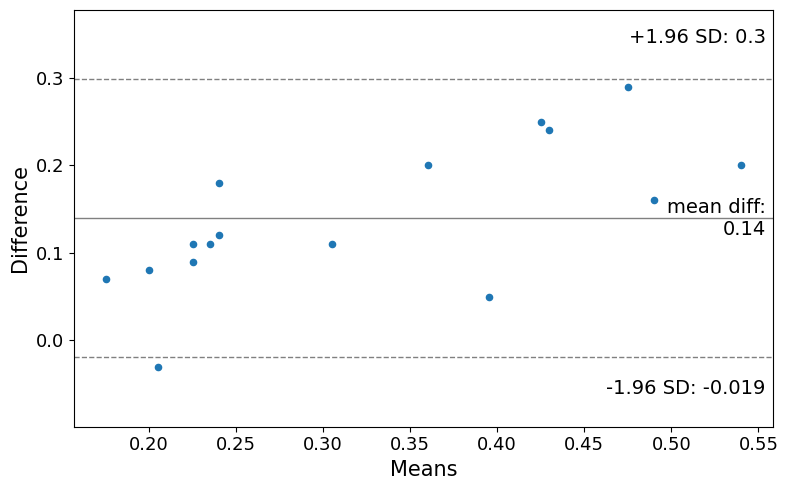

In [5]:
#create Bland-Altman plot                  
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(peak_knee_moments_OG, peak_knee_moments_PyCGM2, ax = ax)

#display Bland-Altman plot
plt.show()
f.savefig('Outputs/peak knee moments bland altman.png', bbox_inches='tight')

In [6]:
#2-sample Kolmogorov-Smirnov test comparison of gait cycle distributions as a whole

#initialise hip variables
H_subject = []
H_ks_statistic = []
H_p_value = []
#initialise knee variables
K_subject = []
K_ks_statistic = []
K_p_value = []

#For the hip
for OG_col, PyCGM2_col in zip(hip_OG_moments.columns, hip_PyCGM2_moments.columns):
    ks_output = stats.kstest(hip_OG_moments[OG_col], hip_PyCGM2_moments[PyCGM2_col])
    H_ks_statistic.append(ks_output[0])
    H_p_value.append(ks_output[1])
    H_subject.append(PyCGM2_col.split(';')[0]) 
    
#For the knee
for OG_col, PyCGM2_col in zip(knee_OG_moments.columns, knee_PyCGM2_moments.columns):
    ks_output = stats.kstest(knee_OG_moments[OG_col], knee_PyCGM2_moments[PyCGM2_col])
    K_ks_statistic.append(ks_output[0])
    K_p_value.append(ks_output[1])
    K_subject.append(PyCGM2_col.split(';')[0])
           
min_values = []
max_values = []
mean_values = []
for col in [H_ks_statistic, H_p_value, K_ks_statistic, K_p_value]:
    min_values.append(np.array(col).min())
    max_values.append(np.array(col).max())
    mean_values.append(np.array(col).mean())
    
Kolmogorov_Smirnov_Results = pd.DataFrame(data=np.array([H_ks_statistic,H_p_value,K_ks_statistic,K_p_value]), index=['Hip KS Statistic','Hip p-Value','Knee KS Statistic','knee p-Value'], columns=H_subject)

Kolmogorov_Smirnov_Results['Maximum'] = max_values
Kolmogorov_Smirnov_Results['Minimum'] = min_values
Kolmogorov_Smirnov_Results['Mean'] = mean_values

Full_Cycle_Kolmogorov_Smirnov_Results = Kolmogorov_Smirnov_Results

Full_Cycle_Kolmogorov_Smirnov_Results.T.to_csv('Outputs/Kolmogorov-Smirnov test FULL.csv')

In [7]:
#2-sample Kolmogorov-Smirnov test comparison of gait cycle distributions during swing only

#initialise hip variables
H_subject = []
H_ks_statistic = []
H_p_value = []
#initialise knee variables
K_subject = []
K_ks_statistic = []
K_p_value = []

#For the hip
for OG_col, PyCGM2_col in zip(hip_OG_swing_moments.columns, hip_PyCGM2_swing_moments.columns):
    ks_output = stats.kstest(hip_OG_swing_moments[OG_col], hip_PyCGM2_swing_moments[PyCGM2_col])
    H_ks_statistic.append(ks_output[0])
    H_p_value.append(ks_output[1])
    H_subject.append(PyCGM2_col.split(';')[0]) 
    
#For the knee
for OG_col, PyCGM2_col in zip(knee_OG_swing_moments.columns, knee_PyCGM2_swing_moments.columns):
    ks_output = stats.kstest(knee_OG_swing_moments[OG_col], knee_PyCGM2_swing_moments[PyCGM2_col])
    K_ks_statistic.append(ks_output[0])
    K_p_value.append(ks_output[1])
    K_subject.append(PyCGM2_col.split(';')[0])
           
min_values = []
max_values = []
mean_values = []
for col in [H_ks_statistic, H_p_value, K_ks_statistic, K_p_value]:
    min_values.append(np.array(col).min())
    max_values.append(np.array(col).max())
    mean_values.append(np.array(col).mean())
    
Kolmogorov_Smirnov_Results_Swing = pd.DataFrame(data=np.array([H_ks_statistic,H_p_value,K_ks_statistic,K_p_value]), index=['Hip KS Statistic','Hip p-Value','Knee KS Statistic','Knee p-Value'], columns=H_subject)

Kolmogorov_Smirnov_Results_Swing['Maximum'] = max_values
Kolmogorov_Smirnov_Results_Swing['Minimum'] = min_values
Kolmogorov_Smirnov_Results_Swing['Mean'] = mean_values

Swing_Phase_Kolmogorov_Smirnov_Results = Kolmogorov_Smirnov_Results_Swing

Swing_Phase_Kolmogorov_Smirnov_Results.T.to_csv('Outputs/Kolmogorov-Smirnov test SWING.csv')

C:\Users\arthu\AppData\Local\Temp\ipykernel_12000\2843478944.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 20, 40, 60, 80, 100])


Index locations of gait cycle where significant differences were found (n=50): [ 2 31 32 33 34 35 44 45 46 47 48 49]


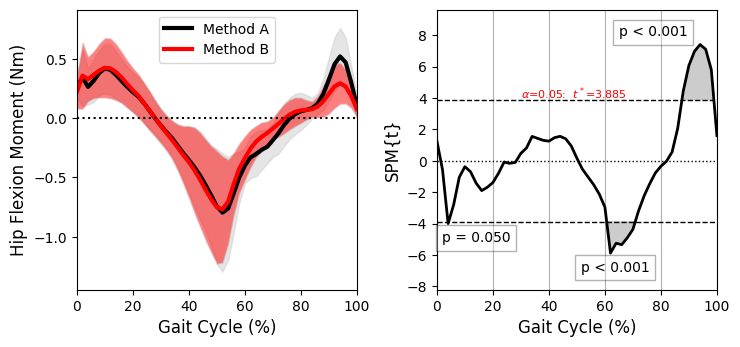

In [26]:
#SMP paired t-test of hip flexion moments

#data has to be a 2D numpy array with float data
Y0 = np.array(hip_OG_moments, dtype='float64')
Y1 = np.array(hip_PyCGM2_moments, dtype='float64')

#conduct paired t-test
alpha      = 0.05
t          = spm1d.stats.ttest_paired(Y0.T, Y1.T) #repeats should be dimension 1, data should be dimension 2
ti         = t.inference(alpha, two_tailed=True)

#plot:
plt.close('all')
### plot mean and SD:
plt.figure( figsize=(8, 3.5) )
ax = plt.axes( (0.1, 0.15, 0.35, 0.8) )
spm1d.plot.plot_mean_sd(Y0.T, x=np.arange(0,Y0.T.shape[1]*2,2), label='Method A')
spm1d.plot.plot_mean_sd(Y1.T, x=np.arange(0,Y0.T.shape[1]*2,2), linecolor='r', facecolor='r', label='Method B')
ax.axhline(y=0, color='k', linestyle=':')
ax.legend(loc='upper center')
ax.set_xlabel('Gait Cycle (%)', fontsize=12)
ax.set_ylabel('Hip Flexion Moment (Nm)', fontsize=12)
### plot SPM results:
ax = plt.axes((0.55,0.15,0.35,0.8))
ti.plot(plot_ylabel=False)
ti.plot_threshold_label(fontsize=8, pos=(15,4))
ti.plot_p_values(size=10, offsets=[(5,-1), (-1,-2),(-8,2.5)])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_xlabel('Gait Cycle (%)', fontsize=12)
ax.set_ylabel('SPM{t}', fontsize=12)
ax.grid(visible=True, which='both', axis='x')
plt.savefig('Outputs/SMP paired t-test of hip flexion moments.png')
print('Index locations of gait cycle where significant differences were found (n=50):', (np.where((ti.z < -3.9) | (ti.z > 3.9))[0]))

C:\Users\arthu\AppData\Local\Temp\ipykernel_12000\4083024563.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 20, 40, 60, 80, 100])


Index locations of gait cycle where significant differences were found (n=50): [ 2 33 34 35 43 44 45 46 47 48 49]


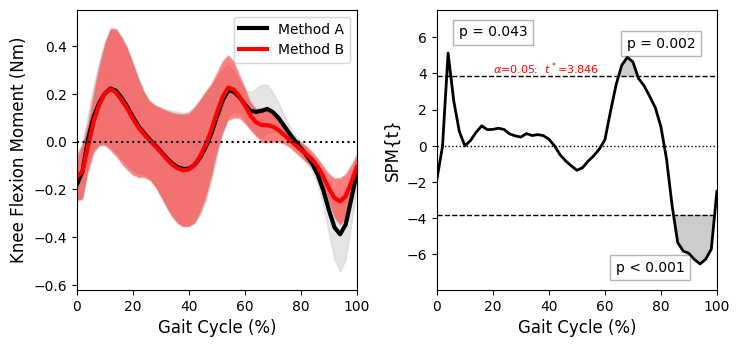

In [25]:
#SMP paired t-test of knee flexion moments

Y0 = np.array(knee_OG_moments, dtype='float64')
Y1 = np.array(knee_PyCGM2_moments, dtype='float64')

#conduct paired t-test
alpha      = 0.05
t          = spm1d.stats.ttest_paired(Y0.T, Y1.T)
ti         = t.inference(alpha, two_tailed=True)

#plot:
plt.close('all')
### plot mean and SD:
plt.figure( figsize=(8, 3.5) )
ax = plt.axes( (0.1, 0.15, 0.35, 0.8) )
spm1d.plot.plot_mean_sd(Y0.T, x=np.arange(0,Y0.T.shape[1]*2,2), label='Method A')
spm1d.plot.plot_mean_sd(Y1.T, x=np.arange(0,Y0.T.shape[1]*2,2), linecolor='r', facecolor='r', label='Method B')
ax.axhline(y=0, color='k', linestyle=':')
ax.legend(loc='upper right')
ax.set_xlabel('Gait Cycle (%)', fontsize=12)
ax.set_ylabel('Knee Flexion Moment (Nm)', fontsize=12)
### plot SPM results:
ax = plt.axes((0.55,0.15,0.35,0.8))
ti.plot(plot_ylabel=False)
ti.plot_threshold_label(fontsize=8, pos=(10,4))
ti.plot_p_values(size=10, offsets=[(8,2),(6,1.3),(-8,-1.2)])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_xlabel('Gait Cycle (%)', fontsize=12)
ax.set_ylabel('SPM{t}', fontsize=12)
plt.savefig('Outputs/SMP paired t-test of knee flexion moments.png')
print('Index locations of gait cycle where significant differences were found (n=50):', (np.where((ti.z < -3.9) | (ti.z > 3.9))[0]))

In [4]:
#Analyse Interial Parameter Data

inertial_data = pd.read_csv('InertialParameters.csv', header=None)

#drop the columns with sides that are not relevant - i.e. only interested with prosthesis side
#locations_of_unwanted_data = np.array([0,2,4,6,8,10,12,14,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,55,57,59,61,63,65,67,69,87,89,91,93,96,98,100,102]) + 1
#data = data.drop(locations_of_unwanted_data, axis=1)

#create headers from the first 3 rows (name, method A or B, and side and joint)
headers = inertial_data.iloc[0].str.cat(inertial_data.iloc[1].str.cat(inertial_data.iloc[2], sep='; '), sep='; ')

#assign the headers and indexs, drop the rows with header information, and the colomns with index information
inertial_data = inertial_data.drop([0,1,2])
inertial_data.index = inertial_data[0]
inertial_data.columns.name = None
inertial_data.index.name = None
inertial_data = inertial_data.drop([0], axis=1)
inertial_data.columns = headers[1:]


#seperate the cad and dempster data
CAD_derived = inertial_data[inertial_data.columns[inertial_data.columns.str.contains('CAD')]].astype(dtype=np.float32)
dempster_derived = inertial_data[inertial_data.columns[inertial_data.columns.str.contains('Dempster')]].astype(dtype=np.float32)

In [5]:
headers = []
n_repeats = []
means = []
perc_means = []
medians = []
stdvs = []
t_stats = []
p_values = []
high_CIs = []
low_CIs = []
stats_tests_names = ['n', 'Mean', 'Mean of Percentage Difference','Median', 'Standard Deviation', 'Paired T-Test Statistic', 'p-Value', '95% Confidence Interval', '5% Confidence Interval']
outliers_file = open("Outputs/Inertial Outliers.txt","w+")
perc_diffs = []
normaility_test_inertial = open("Outputs/Normality Test Inertial.txt","w+")
normaility_test_inertial.write('The Shapiro Wilks test for normality resulted in: \n')




for demp_col, CAD_col in zip(dempster_derived,CAD_derived):  
    print(demp_col,CAD_col)
    #results header values
    headers.append("".join([demp_col.split(';')[1], demp_col.split(';')[2]]))
    
    #n repeats
    n_repeats.append(len(dempster_derived[demp_col].dropna()))
    
    #difference
    differences = dempster_derived[demp_col].dropna() - CAD_derived[CAD_col].dropna()
    #percentage difference
    percentage_differences = 100*differences/dempster_derived[demp_col].dropna()
    #outliers 25 perc, 75 perc iqr
    iqr = stats.iqr(differences)
    p75, p25 = np.percentile(differences, [75, 25])
    outliers = differences[(differences < (p25 - 1.5*iqr)) & (differences < (p75 + 1.5*iqr))]
    outliers_file.write('Outliers in column comparison {} to {}, are {}.'.format(demp_col,CAD_col,outliers))
    outliers_file.write('\r\n')
    #print(outliers)
    
    #normality
    normaility_test_inertial.write(str(stats.shapiro(differences)) + 'for the difference in' + demp_col + '\n')
    
    #mean of differences, mean of percentage differences
    means.append(differences.mean())
    perc_means.append(percentage_differences.mean())
    
    #median of differences
    medians.append(np.median(differences))
    
    #stdv of differences
    stdvs.append(np.std(differences))
    
    print(power_analysis.power(differences.mean()/np.std(differences), len(differences), 0.05, df=None, alternative='two-sided'))
    
    #paired t-test
    #t stat
    t_stats.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[0])
    #p value
    p_values.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[1])
    
    #confidence intervals
    high_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[1])
    low_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[0])

normaility_test_inertial.close()
outliers_file.close()
Inertial_Differences_Statistics = pd.DataFrame(data=np.array([n_repeats,means,perc_means,medians,stdvs,t_stats,p_values,high_CIs,low_CIs]), index=stats_tests_names, columns=headers)
Inertial_Differences_Statistics.to_csv('Outputs/Interial Parameter Summary Statistics.csv')



Dempster; Thigh; Input Mass CAD; Thigh; Input Mass
0.1571537778084118
Dempster; Thigh; Input CoM CAD; Thigh; Input CoM
0.0650756192459613
Dempster; Thigh; Input MoI CAD; Thigh; Input MoI
0.17793353407165233
Dempster; Shank; Input Mass CAD; Shank; Input Mass
0.9911591706796526
Dempster; Shank; Input CoM CAD; Shank; Input CoM
0.5580566492337409
Dempster; Shank; Input MoI CAD; Shank; Input MoI
0.9999999994849073
Dempster; Foot; CoM Sag CAD; Foot; CoM Sag
0.8789913971501058
Dempster; Foot; CoM Trans CAD; Foot; CoM Trans
0.14719518320236286
Dempster; Foot; CoM Long CAD; Foot; CoM Long
0.9983911096898306
Dempster; Foot; Input Mass CAD; Foot; Input Mass
0.9996115371440273
Dempster; Foot; Input MoI CAD; Foot; Input MoI
0.9999991221392629


In [13]:
headers = []
n_repeats = []
means = []
perc_means = []
medians = []
stdvs = []
t_stats = []
p_values = []
high_CIs = []
low_CIs = []
stats_tests_names = ['n', 'Mean', 'Mean of Percentage Difference','Median', 'Standard Deviation', 'Paired T-Test Statistic', 'p-Value', '95% Confidence Interval', '5% Confidence Interval']
outliers_file = open("Outputs/Inertial Outliers.txt","w+")
perc_diffs = []
normaility_test_inertial = open("Outputs/Normality Test Inertial.txt","w+")
normaility_test_inertial.write('The Shapiro Wilks test for normality resulted in: \n')




for demp_col, CAD_col in zip(dempster_derived,CAD_derived):    
    #results header values
    headers.append("".join([demp_col.split(';')[1], demp_col.split(';')[2]]))
    
    #n repeats
    n_repeats.append(len(dempster_derived[demp_col].dropna()))
    
    #difference
    differences = dempster_derived[demp_col].dropna() - CAD_derived[CAD_col].dropna()
    #percentage difference
    percentage_differences = 100*differences/dempster_derived[demp_col].dropna()
    differences = percentage_differences
    #outliers 25 perc, 75 perc iqr
    iqr = stats.iqr(differences)
    p75, p25 = np.percentile(differences, [75, 25])
    outliers = differences[(differences < (p25 - 1.5*iqr)) & (differences < (p75 + 1.5*iqr))]
    outliers_file.write('Outliers in column comparison {} to {}, are {}.'.format(demp_col,CAD_col,outliers))
    outliers_file.write('\r\n')
    #print(outliers)
    
    #normality
    normaility_test_inertial.write(str(stats.shapiro(differences)) + 'for the difference in' + demp_col + '\n')
    
    #mean of differences, mean of percentage differences
    means.append(differences.mean())
    perc_means.append(percentage_differences.mean())
    
    #median of differences
    medians.append(np.median(differences))
    
    #stdv of differences
    stdvs.append(np.std(differences))
    
    #paired t-test
    #t stat
    t_stats.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[0])
    #p value
    p_values.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[1])
    
    #confidence intervals
    high_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[1])
    low_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[0])

normaility_test_inertial.close()
outliers_file.close()
Inertial_Differences_Statistics = pd.DataFrame(data=np.array([n_repeats,means,perc_means,medians,stdvs,t_stats,p_values,high_CIs,low_CIs]), index=stats_tests_names, columns=headers)
Inertial_Differences_Statistics.to_csv('Outputs/Interial Parameter Summary Statistics Percentage Formatt.csv')

In [14]:
inertial_data_AK_BK = pd.read_csv('InertialParameters_BKversusAK.csv')
inertial_data_AK_BK
shank_mass_tt_result = stats.ttest_ind(inertial_data_AK_BK['Mass AK'].dropna().astype('float32'), inertial_data_AK_BK['Mass BK'].dropna().astype('float32'))
shank_MoI_tt_result = stats.ttest_ind(inertial_data_AK_BK['MoI AK'].dropna().astype('float32'), inertial_data_AK_BK['MoI BK'].dropna().astype('float32'))
Above_Below_Shank_parameters_ttest_file = open("Outputs/2 Sample T test, percentage shank mass, MoI differeences, transtib versus transfem.txt","w+")
Above_Below_Shank_parameters_ttest_file.write('The 2 sample t test to compare the % differences between above knee and below knee difference in shank mass and MoI are: \n')
Above_Below_Shank_parameters_ttest_file.write(str(shank_mass_tt_result) + 'for shank mass, and \n')
Above_Below_Shank_parameters_ttest_file.write(str(shank_MoI_tt_result) + 'for shank MoI. \n')
Above_Below_Shank_parameters_ttest_file.close()

In [15]:
headers = []
n_repeats = []
means = []
perc_means = []
medians = []
stdvs = []
t_stats = []
p_values = []
high_CIs = []
low_CIs = []
stats_tests_names = ['n', 'Mean', 'Mean of Percentage Difference','Median', 'Standard Deviation', 'Paired T-Test Statistic', 'p-Value', '95% Confidence Interval', '5% Confidence Interval']
outliers_file = open("Outputs/Inertial Outliers.txt","w+")
perc_diffs = []
normaility_test_inertial = open("Outputs/Normality Test Inertial.txt","w+")
normaility_test_inertial.write('The Shapiro Wilks test for normality resulted in: \n')




for demp_col, CAD_col in zip(dempster_derived,CAD_derived):    
    #results header values
    headers.append("".join([demp_col.split(';')[1], demp_col.split(';')[2]]))
    
    #n repeats
    n_repeats.append(len(dempster_derived[demp_col].dropna()))
    
    #difference
    differences = dempster_derived[demp_col].dropna() - CAD_derived[CAD_col].dropna()
    #percentage difference
    percentage_differences = 100*differences/dempster_derived[demp_col].dropna()
    #outliers 25 perc, 75 perc iqr
    iqr = stats.iqr(differences)
    p75, p25 = np.percentile(differences, [75, 25])
    outliers = differences[(differences < (p25 - 1.5*iqr)) & (differences < (p75 + 1.5*iqr))]
    outliers_file.write('Outliers in column comparison {} to {}, are {}.'.format(demp_col,CAD_col,outliers))
    outliers_file.write('\r\n')
    #print(outliers)
    
    #normality
    normaility_test_inertial.write(str(stats.shapiro(differences)) + 'for the difference in' + demp_col + '\n')
    
    #mean of differences, mean of percentage differences
    means.append(differences.mean())
    perc_means.append(percentage_differences.mean())
    
    #median of differences
    medians.append(np.median(differences))
    
    #stdv of differences
    stdvs.append(np.std(differences))
    
    #paired t-test
    #t stat
    t_stats.append(stats.wilcoxon(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[0])
    #p value
    p_values.append(stats.wilcoxon(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna())[1])
    
    #confidence intervals
    high_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[1])
    low_CIs.append(stats.ttest_rel(dempster_derived[demp_col].dropna(), CAD_derived[CAD_col].dropna()).confidence_interval(confidence_level=0.95)[0])

normaility_test_inertial.close()
outliers_file.close()
Inertial_Differences_Statistics = pd.DataFrame(data=np.array([n_repeats,means,perc_means,medians,stdvs,t_stats,p_values,high_CIs,low_CIs]), index=stats_tests_names, columns=headers)
Inertial_Differences_Statistics.to_csv('Outputs/Interial Parameter Summary Statistics wilcoxon.csv')

In [16]:
percentage_differences_df = pd.DataFrame(data=[hip_moment_percentage_difference,knee_moment_percentage_difference], index = ['Hip Moment Percentage Difference','Knee Moment Percentage Difference'], columns = hip_OG_swing_moments.columns)
percentage_differences_df.T.to_csv('Outputs/Subject Peak Moment Percentage Difference.csv')


In [17]:
#is there a difference between differences in peak moments for above knee and below knee amputees?

#get data for differences in swing phase moments 
peak_hip_moments_OG = np.array(hip_OG_swing_moments.abs().max())
peak_hip_moments_PyCGM2 = np.array(hip_PyCGM2_swing_moments.abs().max())
peak_knee_moments_OG = np.array(knee_OG_swing_moments.abs().max())
peak_knee_moments_PyCGM2 = np.array(knee_PyCGM2_swing_moments.abs().max())
#difference between OG and PyCGM2 peak moments
hip_moment_difference = peak_hip_moments_OG - peak_hip_moments_PyCGM2
knee_moment_difference = peak_knee_moments_OG - peak_knee_moments_PyCGM2
#seperate this into above and below knee amputees
#need to know who is who
subject = []
for col in hip_OG_swing_moments.columns:
    subject.append(col.split(';')[0])
#in subject, the index values of above knee amputees are 0, 1, 9, 12, 13     
above_knee_hip_M_D = hip_moment_difference[[0, 1, 9, 12, 13]].astype('float16')
below_knee_hip_M_D = np.delete(hip_moment_difference, [[0, 1, 9, 12, 13]]).astype('float16')
above_knee_knee_M_D = knee_moment_difference[[0, 1, 9, 12, 13]].astype('float16')
below_knee_knee_M_D = np.delete(knee_moment_difference, [[0, 1, 9, 12, 13]]).astype('float16')

Above_Below_Peak_Moments_ttest_file = open("Outputs/2 Sample T test, peak flexion moments, swing, transtib versus transfem.txt","w+")
Above_Below_Peak_Moments_ttest_file.write('The 2 sample t test to compare differences between above knee and below knee difference in peak hip and knee flexion moments are: \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(above_knee_hip_M_D, below_knee_hip_M_D)) + 'for peak hip flexion moments, and \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(above_knee_knee_M_D, below_knee_knee_M_D)) + 'for peak knee flexion moments. \n')
Above_Below_Peak_Moments_ttest_file.close()
#end up with a t stat and pvalue for (1) difference between differences from method A to method B when comparing transfem and transtib subjects
print('The 2 sample t test to compare differences between above knee and below knee difference in peak hip and knee flexion moments are: ')
print(stats.ttest_ind(above_knee_hip_M_D, below_knee_hip_M_D), ' for peak hip flexion moments, and')
print(stats.ttest_ind(above_knee_knee_M_D, below_knee_knee_M_D), ' for peak knee flexion moments.')


The 2 sample t test to compare differences between above knee and below knee difference in peak hip and knee flexion moments are: 
Ttest_indResult(statistic=-0.3250291096574747, pvalue=0.7499652660491025)  for peak hip flexion moments, and
Ttest_indResult(statistic=-1.2982702781379545, pvalue=0.21517492047588752)  for peak knee flexion moments.


In [18]:
#is there a difference between differences in peak moments for above knee and below knee amputees?

#get data for differences in swing phase moments 
peak_hip_moments_OG = np.array(hip_OG_swing_moments.abs().max())
peak_hip_moments_PyCGM2 = np.array(hip_PyCGM2_swing_moments.abs().max())
peak_knee_moments_OG = np.array(knee_OG_swing_moments.abs().max())
peak_knee_moments_PyCGM2 = np.array(knee_PyCGM2_swing_moments.abs().max())
#difference between OG and PyCGM2 peak moments
hip_moment_difference = peak_hip_moments_OG - peak_hip_moments_PyCGM2
knee_moment_difference = peak_knee_moments_OG - peak_knee_moments_PyCGM2
hip_moment_percentage_difference = 100*hip_moment_difference/peak_hip_moments_OG
knee_moment_percentage_difference = 100*knee_moment_difference/peak_knee_moments_OG
#seperate this into above and below knee amputees
#need to know who is who
subject = []
for col in hip_OG_swing_moments.columns:
    subject.append(col.split(';')[0])
#in subject, the index values of above knee amputees are 0, 1, 9, 12, 13     
above_knee_hip_M_D = hip_moment_percentage_difference[[0, 1, 9, 12, 13]].astype('float16')
below_knee_hip_M_D = np.delete(hip_moment_percentage_difference, [[0, 1, 9, 12, 13]]).astype('float16')
above_knee_knee_M_D = knee_moment_percentage_difference[[0, 1, 9, 12, 13]].astype('float16')
below_knee_knee_M_D = np.delete(knee_moment_percentage_difference, [[0, 1, 9, 12, 13]]).astype('float16')

Above_Below_Peak_Moments_ttest_file = open("Outputs/2 Sample T test, percentage peak flexion moments, swing, transtib versus transfem.txt","w+")
Above_Below_Peak_Moments_ttest_file.write('The 2 sample t test to compare the % differences between above knee and below knee difference in peak hip and knee flexion moments are: \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(above_knee_hip_M_D, below_knee_hip_M_D)) + 'for peak hip flexion moments, and \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(above_knee_knee_M_D, below_knee_knee_M_D)) + 'for peak knee flexion moments. \n')
Above_Below_Peak_Moments_ttest_file.close()
#end up with a t stat and pvalue for (1) difference between differences from method A to method B when comparing transfem and transtib subjects
print('The 2 sample t test to compare differences between above knee and below knee difference in peak hip and knee flexion moments are: ')
print(stats.ttest_ind(above_knee_hip_M_D, below_knee_hip_M_D), ' for peak hip flexion moments, and')
print(stats.ttest_ind(above_knee_knee_M_D, below_knee_knee_M_D), ' for peak knee flexion moments.')


The 2 sample t test to compare differences between above knee and below knee difference in peak hip and knee flexion moments are: 
Ttest_indResult(statistic=0.45170899851225976, pvalue=0.6583974522629419)  for peak hip flexion moments, and
Ttest_indResult(statistic=-0.26118918731160773, pvalue=0.7977496600104667)  for peak knee flexion moments.


In [19]:
#is there a difference between differences in peak moments for above knee and below knee amputees?

#get data for differences in swing phase moments 
peak_hip_moments_OG = np.array(hip_OG_swing_moments.abs().max())
peak_hip_moments_PyCGM2 = np.array(hip_PyCGM2_swing_moments.abs().max())
peak_knee_moments_OG = np.array(knee_OG_swing_moments.abs().max())
peak_knee_moments_PyCGM2 = np.array(knee_PyCGM2_swing_moments.abs().max())
#difference between OG and PyCGM2 peak moments
hip_moment_difference = peak_hip_moments_OG - peak_hip_moments_PyCGM2
knee_moment_difference = peak_knee_moments_OG - peak_knee_moments_PyCGM2

hip_moment_percentage_difference = 100*hip_moment_difference/peak_hip_moments_OG
knee_moment_percentage_difference = 100*knee_moment_difference/peak_knee_moments_OG

Above_Below_Peak_Moments_ttest_file = open("Outputs/2 Sample T test, peak flexion moments, swing, hip versus knee.txt","w+")
Above_Below_Peak_Moments_ttest_file.write('The 2 sample t test to compare differences between peak hip and knee flexion moment differences are: \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(hip_moment_difference.astype('float32'), knee_moment_difference.astype('float32'))) + 'for peak hip flexion moments, and \n')
Above_Below_Peak_Moments_ttest_file.write('the 2 sample t test to compare percentage differences between peak hip and knee flexion moment differences are: \n')
Above_Below_Peak_Moments_ttest_file.write(str(stats.ttest_ind(hip_moment_percentage_difference.astype('float32'), knee_moment_percentage_difference.astype('float32'))) + 'for peak hip flexion moments, and \n')
Above_Below_Peak_Moments_ttest_file.close()
